In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pwd

'/home/bene/projects/generative-models/examples/torch_autoencoder'

In [3]:
%cd ../..
%pwd

/home/bene/projects/generative-models


'/home/bene/projects/generative-models'

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np

from gempy.torch.encoder import ConvEncoder as Encoder
from gempy.torch.decoder import ConvTDecoder as Decoder
from gempy.torch.variational_auto_encoder import VariationalAutoEncoder

import matplotlib.pyplot as plt

In [5]:
def get_MNIST(batch_size, dataset_directory, dataloader_workers, source='MNIST'):
    # Prepare dataset for training
    train_transformation = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
    
    data_source = getattr(torchvision.datasets, source)
    
    train_dataset = data_source(root=dataset_directory, train=True, download=True, transform=train_transformation)

    test_dataset =  data_source(root=dataset_directory, train=False, download=True, transform=train_transformation)

    # Prepare Data Loaders for training and validation
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               pin_memory=True, num_workers=dataloader_workers)

    # Prepare Data Loaders for training and validation
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                              pin_memory=True, num_workers=dataloader_workers)

    return train_dataset, test_dataset, train_loader, test_loader

In [6]:
ENCODER_DROPOUT = 0.3
DECODER_DROPOUT = 0.2
USE_BATCHNORM = True

BATCHSIZE = 32
LEARNINGRATE = 0.005

train_dataset, test_dataset, train_loader, test_loader = get_MNIST(
    BATCHSIZE, 'examples/datset', 12, 'MNIST'
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting examples/datset/MNIST/raw/train-images-idx3-ubyte.gz to examples/datset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting examples/datset/MNIST/raw/train-labels-idx1-ubyte.gz to examples/datset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting examples/datset/MNIST/raw/t10k-images-idx3-ubyte.gz to examples/datset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting examples/datset/MNIST/raw/t10k-labels-idx1-ubyte.gz to examples/datset/MNIST/raw

Processing...
Done!


/home/bene/anaconda3/envs/gempy/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
def show_latent(data_loader=test_loader):
    y_latent = []
    y_labels = []
    for batch_features, batch_labels in data_loader:
        batch_features = batch_features.to(device)
        y = encoder(batch_features)[0].detach().cpu().numpy()
        y_latent.extend(y)
        y_labels.extend(batch_labels.numpy())

    y_latent = np.asarray(y_latent)
    y_labels = np.asarray(y_labels)
    
    digit_map = [y_labels == i for i in range(10)]
    
    plt.figure(figsize=(10,10))
    for i, where_i in enumerate(digit_map):
        selection = y_latent[where_i]    
        plt.scatter(*selection[...,:2].T, label=f'#{i}', alpha=0.5)
    plt.legend()
    
    return y_latent

input shape: (1, 28, 28)


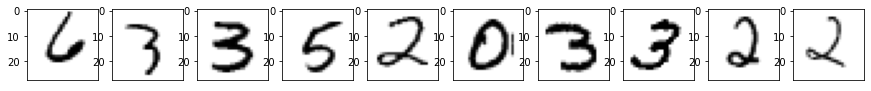

In [8]:
f, axes = plt.subplots(1, 10, figsize=(15, 5))
for ax in axes:
    tensor = train_dataset[np.random.randint(len(train_dataset))][0]
    ax.imshow(tensor.detach().numpy().transpose(1,2,0), cmap='binary')
    ax.set_xticks([]); ax.set_yticks

input_shape = tuple(train_dataset[0][0].shape)
print('input shape:', input_shape)

In [9]:
z_dim = (2, 2)
z_labels = ('mu', 'log_var')

In [10]:
device = 'cpu'
if torch.cuda.is_available():
    print (f'GPU available')
    device = 'cuda'

x_random = torch.randn(1, *input_shape)
x_random = x_random.to(device)

GPU available


In [11]:
encoder = Encoder(
    input_shape=input_shape,
    filters=(32, 64, 64, 64),
    kernels_size=(3, 3, 3, 3),
    strides=(1, 2, 2, 1),
    activation='elu',
    latent_dim=z_dim,
    latent_labels=z_labels,
    latent_activation=None,
    use_dropout=ENCODER_DROPOUT,
    use_batch_norm=USE_BATCHNORM
)

encoder = encoder.to(device)

print('Encoder:')
for l in encoder.conv_stack:
    print('- label:', l[0], '\tshape:', l[-1], '\tactivation:', l[-2])
for l in encoder.latent_stack:
    print('- label:', l[0], '\tshape:', l[-1], '\tactivation:', l[-2])    

Encoder:
- label: conv_0 	shape: (32, 28, 28) 	activation: None
- label: batch_norm_0 	shape: (32, 28, 28) 	activation: <function elu at 0x7feebfc035e0>
- label: drop_0 	shape: (32, 28, 28) 	activation: None
- label: conv_1 	shape: (64, 14, 14) 	activation: None
- label: batch_norm_1 	shape: (64, 14, 14) 	activation: <function elu at 0x7feebfc035e0>
- label: drop_1 	shape: (64, 14, 14) 	activation: None
- label: conv_2 	shape: (64, 7, 7) 	activation: None
- label: batch_norm_2 	shape: (64, 7, 7) 	activation: <function elu at 0x7feebfc035e0>
- label: drop_2 	shape: (64, 7, 7) 	activation: None
- label: conv_3 	shape: (64, 7, 7) 	activation: None
- label: batch_norm_3 	shape: (64, 7, 7) 	activation: <function elu at 0x7feebfc035e0>
- label: drop_3 	shape: (64, 7, 7) 	activation: None
- label: latent_mu 	shape: 2 	activation: None
- label: latent_log_var 	shape: 2 	activation: None


10000 datapoints


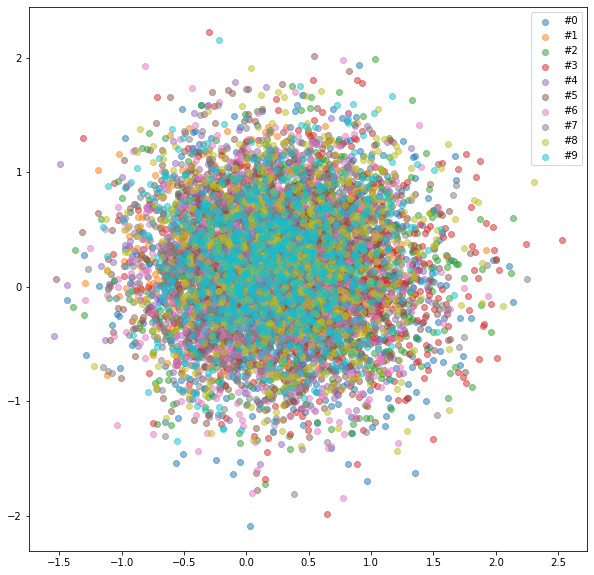

In [12]:
latent_space = show_latent()
print(f'{len(latent_space)} datapoints')

In [13]:
decoder = Decoder(
    latent_dim=z_dim[0],
    latent_upscale=encoder.conv_stack_shape_out,
    filters=[64, 64, 32, 1],
    kernels_size=[3, 4, 4, 3],
    strides=[1, 2, 2, 1],
    activation=['elu', 'elu', 'elu', 'sigmoid'],
    latent_merge=True,
    latent_activation='elu',
    use_dropout=DECODER_DROPOUT,
    use_batch_norm=USE_BATCHNORM
)

decoder = decoder.to('cuda')

print('Decoder:')
for l in decoder.latent_stack:
    print('- label:', l[0], '\tshape:', l[-1], '\tactivation:', l[-2])
for l in decoder.conv_transpose_stack:
    print('- label:', l[0], '\tshape:', l[-1], '\tactivation:', l[-2])

Decoder:
- label: decode_latent_0 	shape: (64, 7, 7) 	activation: <function elu at 0x7feebfc035e0>
- label: decode_conv_t_0 	shape: (64, 7, 7) 	activation: None
- label: decode_batch_norm_0 	shape: (64, 7, 7) 	activation: <function elu at 0x7feebfc035e0>
- label: decode_drop_0 	shape: (64, 7, 7) 	activation: None
- label: decode_conv_t_1 	shape: (64, 14, 14) 	activation: None
- label: decode_batch_norm_1 	shape: (64, 14, 14) 	activation: <function elu at 0x7feebfc035e0>
- label: decode_drop_1 	shape: (64, 14, 14) 	activation: None
- label: decode_conv_t_2 	shape: (32, 28, 28) 	activation: None
- label: decode_batch_norm_2 	shape: (32, 28, 28) 	activation: <function elu at 0x7feebfc035e0>
- label: decode_drop_2 	shape: (32, 28, 28) 	activation: None
- label: decode_conv_t_3 	shape: (1, 28, 28) 	activation: <built-in method sigmoid of type object at 0x7fef25170ca0>


In [14]:
model = VariationalAutoEncoder(
    encoder=encoder,
    decoder=decoder,
    #beta=0.1, reconstruction_loss='gaussian_likelihood'
    beta=1e3, reconstruction_loss='mse_reconstruction_loss'
)

model = model.to(device)
model

VariationalAutoEncoder(
  (encoder): ConvEncoder(
    (conv_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_0): Dropout(p=0.3, inplace=False)
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_1): Dropout(p=0.3, inplace=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_norm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_2): Dropout(p=0.3, inplace=False)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_3): Dropout(p=0.3, inplace=False)
    (latent_flatten): Flatten(start_dim=1, end_dim=-1)


In [15]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
log_scale 	 torch.Size([1])
encoder.conv_0.weight 	 torch.Size([32, 1, 3, 3])
encoder.conv_0.bias 	 torch.Size([32])
encoder.batch_norm_0.weight 	 torch.Size([32])
encoder.batch_norm_0.bias 	 torch.Size([32])
encoder.batch_norm_0.running_mean 	 torch.Size([32])
encoder.batch_norm_0.running_var 	 torch.Size([32])
encoder.batch_norm_0.num_batches_tracked 	 torch.Size([])
encoder.conv_1.weight 	 torch.Size([64, 32, 3, 3])
encoder.conv_1.bias 	 torch.Size([64])
encoder.batch_norm_1.weight 	 torch.Size([64])
encoder.batch_norm_1.bias 	 torch.Size([64])
encoder.batch_norm_1.running_mean 	 torch.Size([64])
encoder.batch_norm_1.running_var 	 torch.Size([64])
encoder.batch_norm_1.num_batches_tracked 	 torch.Size([])
encoder.conv_2.weight 	 torch.Size([64, 64, 3, 3])
encoder.conv_2.bias 	 torch.Size([64])
encoder.batch_norm_2.weight 	 torch.Size([64])
encoder.batch_norm_2.bias 	 torch.Size([64])
encoder.batch_norm_2.running_mean 	 torch.Size([64])
encoder.batch_norm_2.running

In [16]:
print('input shape     :', model.encoder.conv_stack_shape_in)
print('latent shape     :', model.encoder.conv_stack_shape_out)
print('z shape          :', (z_dim[0],))
print('output shape    :', model.decoder.conv_transpose_stack_shape_out)

input shape     : (1, 28, 28)
latent shape     : (64, 7, 7)
z shape          : (2,)
output shape    : (1, 28, 28)


In [17]:
y = model(x_random)

print('latent space    :', encoder.latent_torch)
print('output shape    :', y.shape)


latent space    : None
output shape    : torch.Size([1, 1, 28, 28])


In [18]:
BATCHSIZE = 32
LEARNINGRATE = 0.0005

EPOCHS = 200
WINDOW = 5
STOPPING = 1e-3

N_BATCHSIZE_UPDATES = 5

In [19]:
# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(),  # link to VAE parameters
                             lr=LEARNINGRATE)     # set learning rate

In [20]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0005, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]}]


In [21]:
loss_history = []
kl_loss_history = []
r_loss_history = []
valid_history = []
variations = []

In [30]:
def early_stopping(loss_history, rate=1e-4, window=5):
    if len(loss_history) < window:
        return False
    
    if np.absolute(np.std(loss_history[-window:])) < rate:
        print(np.absolute(np.std(loss_history[-window:])))
        return True
    
    return False

batchsize_updates = 0
batchsize_update_rate=1.125

for epoch in range(EPOCHS):
    loss, r_loss, kl_loss = 0, 0, 0

    for batch in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch[0] = batch[0].to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions and elbo_loss
        elbo_loss = model.training_step(batch=batch)
        
        # compute accumulated gradients
        elbo_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += elbo_loss.item()
        r_loss += model.r_loss.item()
        kl_loss += model.kl_loss.item()
    
    valid = 0
    for test_batch in test_loader:
        test_batch[0] = test_batch[0].to(device)
        test_loss = model.training_step(test_batch)
        valid += test_loss.item()
    
    # compute the epoch training loss
    loss_history.append(loss / len(train_loader))
    r_loss_history.append(r_loss / len(train_loader))
    kl_loss_history.append(kl_loss / len(train_loader))                        
    valid_history.append(valid / len(test_loader))
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f} (KL: {:.6f}, RECON.: {:.6f}), valid = {:.6f}".format(epoch + 1, 
                                                                                             EPOCHS, 
                                                                                             loss_history[-1], 
                                                                                             kl_loss_history[-1],
                                                                                             r_loss_history[-1],
                                                                                             valid_history[-1],
                                                                                            ))
    
    if early_stopping(loss_history, rate=STOPPING, window=WINDOW):
        break
    
    if epoch > 0 and epoch % 10 == 0:
        if batchsize_updates < N_BATCHSIZE_UPDATES:
            batchsize_updates += 1
            BATCHSIZE = int(batchsize_update_rate * BATCHSIZE)
            train_dataset, test_dataset, train_loader, test_loader = get_MNIST(
                BATCHSIZE, 'examples/dat/torch_autoencoder/', 12, 'MNIST')
            print(f"update batchsize to {BATCHSIZE}")
            
        else:
            print(f"early stopping: could not improve validation of model in range {STOPPING} in {WINDOW} consecutive epochs")
            break
        
        

epoch : 1/200, loss = 54.212698 (KL: 3.865813, RECON.: 0.050347), valid = 54.019995
epoch : 2/200, loss = 53.765600 (KL: 3.923242, RECON.: 0.049842), valid = 54.236735
epoch : 3/200, loss = 53.446665 (KL: 3.990309, RECON.: 0.049456), valid = 53.387653
epoch : 4/200, loss = 53.116297 (KL: 4.037940, RECON.: 0.049078), valid = 52.740015
epoch : 5/200, loss = 52.850536 (KL: 4.089235, RECON.: 0.048761), valid = 52.639722


KeyboardInterrupt: 

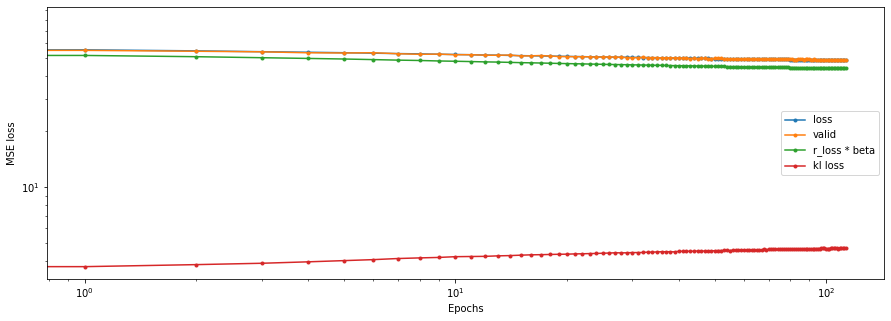

In [26]:
plt.figure(figsize=(15, 5))
plt.loglog(loss_history, marker='.', label='loss')
plt.loglog(valid_history, marker='.', label='valid')
plt.loglog(np.asarray(r_loss_history) * model.beta, marker='.', label='r_loss * beta')
plt.loglog(kl_loss_history, marker='.', label='kl loss')
plt.xlabel('Epochs'); 
plt.ylabel('MSE loss')
plt.legend();

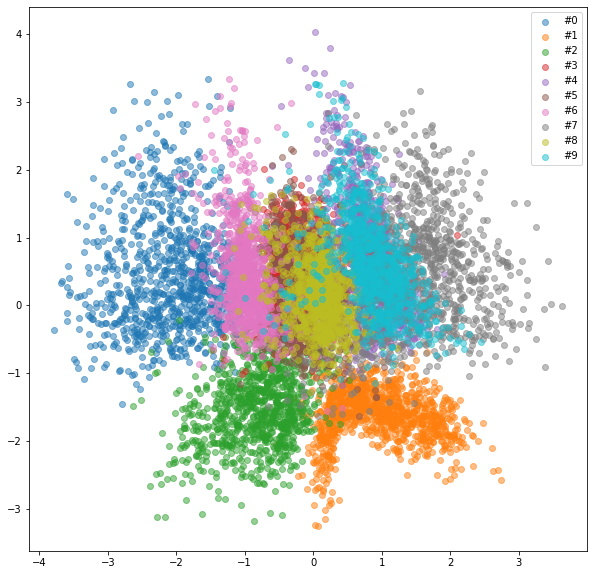

In [27]:
y_latent = show_latent()

In [28]:
y_latent_range = list({'min': li.min(), 'mean': li.mean(), 'max': li.max()} for li in y_latent.T)
y_latent_range

[{'min': -3.7804017, 'mean': 0.01257881, 'max': 3.625726},
 {'min': -3.2558918, 'mean': 0.025608521, 'max': 4.0370836}]

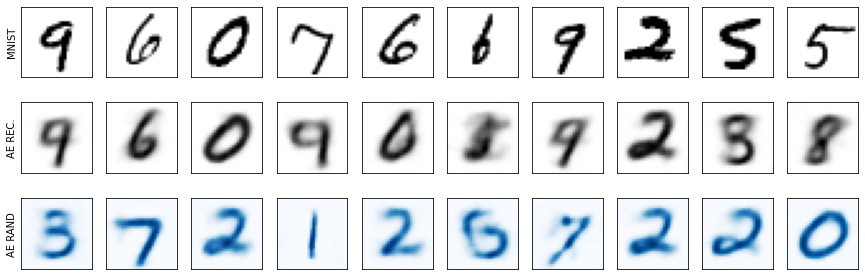

In [29]:
n = 10

z_rand = np.random.rand(n, z_dim[0])
for i in range(z_rand.shape[-1]):
    range_i = (y_latent_range[i]['max'] - y_latent_range[i]['min'])
    offset_i = 0.5 - y_latent_range[i]['mean'] / range_i
    z_rand[..., i] -= offset_i
    z_rand[..., i] *= range_i
    
t_rand = torch.from_numpy(z_rand).float().to(device)
y_rand = model.decoder(t_rand)
y_numpy = y_rand.detach().cpu().numpy()

f, axes = plt.subplots(3, n, figsize=(15, 5))
tensor_choice = [np.random.randint(len(train_dataset)) for __ in range(n)]

my_subset = torch.utils.data.Subset(train_dataset, tensor_choice)
loader = torch.utils.data.DataLoader(my_subset, batch_size=len(tensor_choice))
for tensors, __ in loader:
    reconst = model(tensors.to(device))

    for i, ax in enumerate(axes.T):
        ax[0].imshow(tensors[i].detach().numpy().transpose(1,2,0), cmap='binary')
        ax[1].imshow(reconst[i].detach().cpu().numpy().transpose(1,2,0), cmap='binary')

        ax[2].imshow(y_numpy[i].transpose(1,2,0), cmap='Blues')
        ax[0].set_xticks([]); ax[0].set_yticks([])
        ax[1].set_xticks([]); ax[1].set_yticks([])
        ax[2].set_xticks([]); ax[2].set_yticks([])

    axes[0][0].set_ylabel('MNIST');
    axes[1][0].set_ylabel('AE REC.');
    axes[2][0].set_ylabel('AE RAND');